In [16]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam


In [17]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 45
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

In [18]:
import tensorflow as tf

In [19]:
num_classes = 10

In [20]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

In [21]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [22]:
print(X_test.shape)
X_train.shape

(10000, 32, 32, 3)


(50000, 32, 32, 3)

In [23]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
  global compression
  temp = input
  for _ in range(l):
    BatchNorm = layers.BatchNormalization()(temp)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
    if (dropout_rate>0):
      Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
      concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
    temp = concat
        
  return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
  global compression
  BatchNorm = layers.BatchNormalization()(input)
  relu = layers.Activation('relu')(BatchNorm)
  Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
  if dropout_rate>0:
    Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
  avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
  return avg

#output layer
def output_layer(input):
  global compression
  BatchNorm = layers.BatchNormalization()(input)
  relu = layers.Activation('relu')(BatchNorm)
  AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
  flat = layers.Flatten()(AvgPooling)
  output = layers.Dense(num_classes, activation='softmax')(flat)
  return output

In [24]:
X_train[0].shape

(32, 32, 3)

In [25]:
num_filter = 12
dropout_rate = 0.2
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [26]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 12)   324         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 32, 32, 12)   48          conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 32, 32, 12)   0           batch_normalization_52[0][0]     
____________________________________________________________________________________________

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
DynamicLR =ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, verbose=1, mode='max',min_delta=0, cooldown=0, min_lr=0.0001)

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [29]:
history=model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test),callbacks=[DynamicLR])

Epoch 1/45
391/391 [==============================] - 45s 101ms/step - loss: 1.9460 - accuracy: 0.2754 - val_loss: 2.8759 - val_accuracy: 0.2032
Epoch 2/45
391/391 [==============================] - 38s 98ms/step - loss: 1.4348 - accuracy: 0.4694 - val_loss: 1.4630 - val_accuracy: 0.4842
Epoch 3/45
391/391 [==============================] - 39s 99ms/step - loss: 1.2537 - accuracy: 0.5391 - val_loss: 1.3320 - val_accuracy: 0.5442
Epoch 4/45
391/391 [==============================] - 39s 99ms/step - loss: 1.1374 - accuracy: 0.5859 - val_loss: 1.5929 - val_accuracy: 0.4779
Epoch 5/45
391/391 [==============================] - 39s 99ms/step - loss: 1.0457 - accuracy: 0.6234 - val_loss: 1.3661 - val_accuracy: 0.5521
Epoch 6/45
391/391 [==============================] - 39s 99ms/step - loss: 0.9913 - accuracy: 0.6419 - val_loss: 1.0956 - val_accuracy: 0.6354
Epoch 7/45
391/391 [==============================] - 39s 99ms/step - loss: 0.9377 - accuracy: 0.6637 - val_loss: 1.1892 - val_accuracy

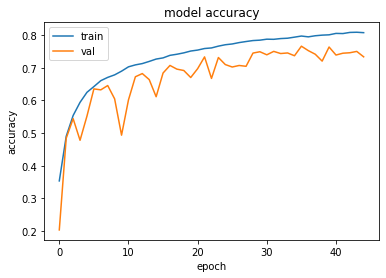

In [30]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

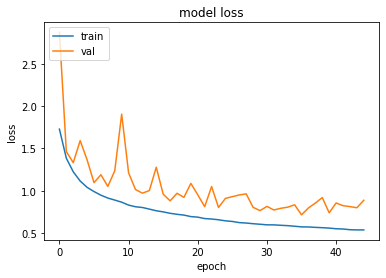

In [31]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

DATA AUGMENTATION

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [33]:
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

In [34]:
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [35]:
model1 = Model(inputs=[input], outputs=[output])
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 32, 32, 12)   324         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_104 (BatchN (None, 32, 32, 12)   48          conv2d_104[0][0]                 
__________________________________________________________________________________________________
activation_104 (Activation)     (None, 32, 32, 12)   0           batch_normalization_104[0][0]    
____________________________________________________________________________________________

In [36]:
DynamicLR =ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=2, verbose=1, mode='max',min_delta=0, cooldown=0, min_lr=0.0001)

In [37]:
model1.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [38]:
history2=model1.fit_generator(datagen.flow(X_train,y_train,batch_size=128),validation_data = (X_test,y_test), steps_per_epoch = 391,epochs=45,callbacks=[DynamicLR])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/45
391/391 [==============================] - 47s 106ms/step - loss: 1.9747 - accuracy: 0.2577 - val_loss: 1.6432 - val_accuracy: 0.4016
Epoch 2/45
391/391 [==============================] - 40s 102ms/step - loss: 1.5056 - accuracy: 0.4402 - val_loss: 1.5382 - val_accuracy: 0.4801
Epoch 3/45
391/391 [==============================] - 40s 103ms/step - loss: 1.3355 - accuracy: 0.5132 - val_loss: 2.3519 - val_accuracy: 0.3519
Epoch 4/45
391/391 [==============================] - 40s 102ms/step - loss: 1.2472 - accuracy: 0.5510 - val_loss: 1.2285 - val_accuracy: 0.5668
Epoch 5/45
391/391 [==============================] - 40s 102ms/step - loss: 1.1888 - accuracy: 0.5658 - val_loss: 1.2924 - val_accuracy: 0.5652
Epoch 6/45
391/391 [==============================] - 40s 102ms/step - loss: 1.1329 - accuracy: 0.5909 - val_loss: 1.1845 - val_accuracy: 0.5982
Epoch 7/45
391/391 [==============================] - 40s 103ms/step - loss: 1.0696 - accuracy: 0.6145 - val_loss: 1.3405 - val_ac

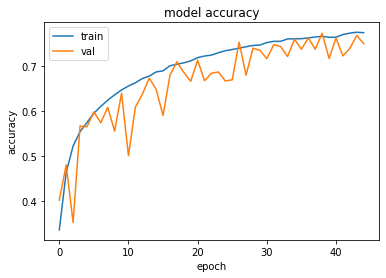

In [39]:
import keras
from matplotlib import pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

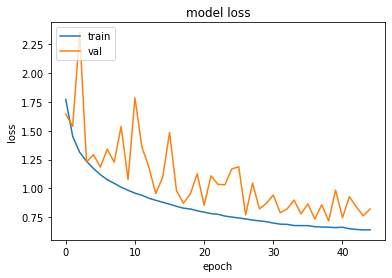

In [40]:
import keras
from matplotlib import pyplot as plt
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()